In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import statsmodels.api as sm

from scipy.stats import bernoulli
from statsmodels.miscmodels.ordinal_model import OrderedModel

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams["font.family"] = "Latin Modern Roman"

In [3]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

In [4]:
def make_data():
    np.random.seed(100)
    salary = np.random.normal(40, 10, 500)
    work_sat = np.random.beta(1, 0.4, 500)
    work_from_home = bernoulli.rvs(0.7, size=500)
    work_from_home_calc = np.where(work_from_home, 1.4 * work_from_home, work_from_home)
    latent_rating = (
        0.08423 * salary
        + 0.2 * work_sat
        + work_from_home_calc
        + np.random.normal(0, 1, 500)
    )
    explicit_rating = np.round(latent_rating, 0)
    df = pd.DataFrame(
        {
            "salary": salary,
            "work_sat": work_sat,
            "work_from_home": work_from_home,
            "latent_rating": latent_rating,
            "explicit_rating": explicit_rating,
        }
    )
    return df


try:
    df = pd.read_csv("../data/fake_employee_manger_rating.csv")
    df = df[
        ["salary", "work_sat", "work_from_home", "latent_rating", "explicit_rating"]
    ]
except FileNotFoundError:
    df = make_data()

K = len(df["explicit_rating"].unique())
df.head()

,salary,work_sat,work_from_home,latent_rating,explicit_rating
0,22.502345,0.735425,1,1.376997,1.0
1,43.426804,0.570354,0,5.419863,5.0
2,51.530358,0.738212,0,5.279701,5.0
3,37.475640,0.346045,1,4.651830,5.0
4,49.813208,0.365451,1,5.788661,6.0


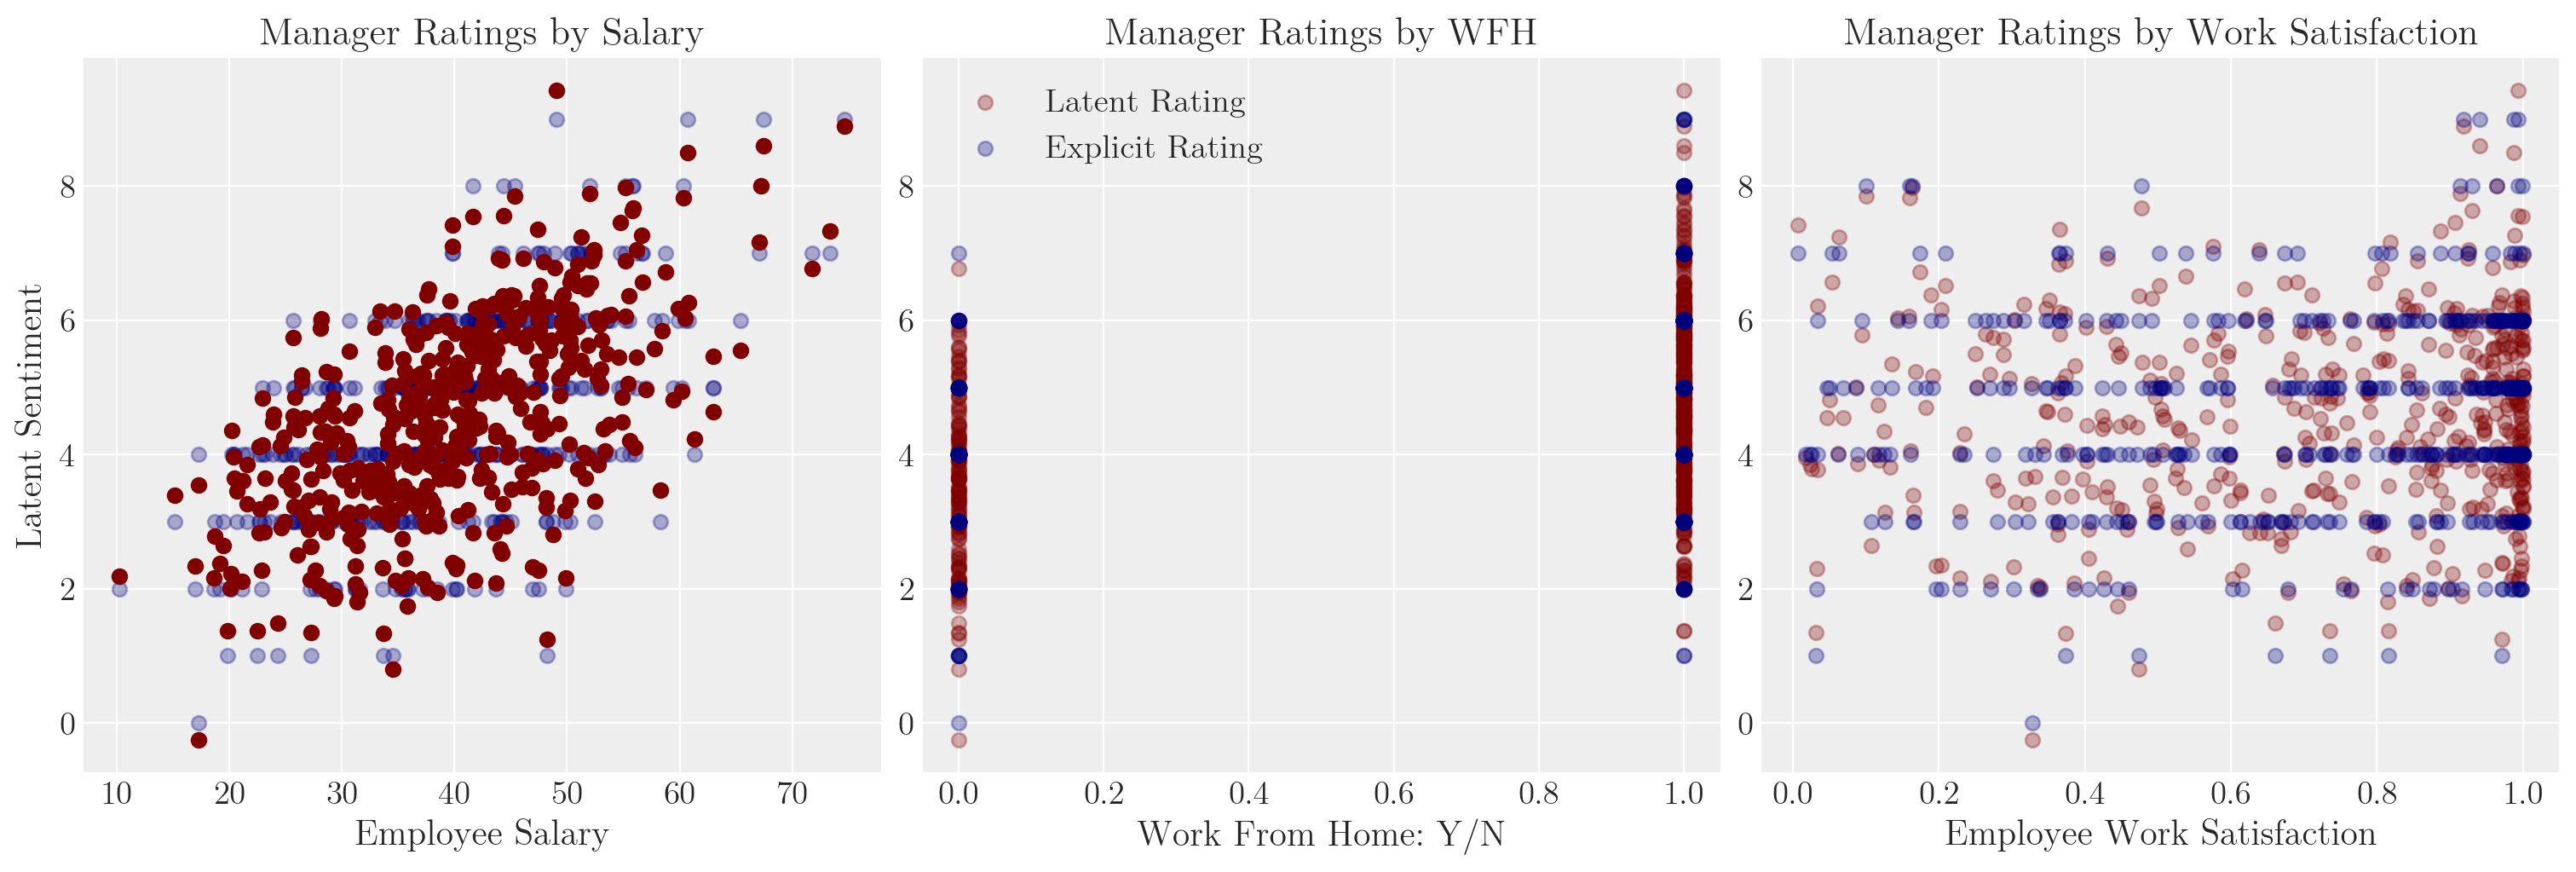

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
ax = axs[0]
ax.scatter(
    df["salary"],
    df["explicit_rating"],
    label="Explicit Rating",
    color="navy",
    alpha=0.3,
)
axs[1].scatter(
    df["work_from_home"],
    df["latent_rating"],
    label="Latent Rating",
    color="maroon",
    alpha=0.3,
)
axs[1].scatter(
    df["work_from_home"],
    df["explicit_rating"],
    label="Explicit Rating",
    c="navy",
    alpha=0.3,
)
axs[2].scatter(
    df["work_sat"], df["latent_rating"], label="Latent Rating", color="maroon", alpha=0.3
)
axs[2].scatter(
    df["work_sat"],
    df["explicit_rating"],
    label="Explicit Rating",
    color="navy",
    alpha=0.3,
)
ax.scatter(df["salary"], df["latent_rating"], label="Latent Sentiment", color="maroon")
ax.set_title("Manager Ratings by Salary")
axs[1].set_title("Manager Ratings by WFH")
axs[2].set_title("Manager Ratings by Work Satisfaction")
ax.set_ylabel("Latent Sentiment")
ax.set_xlabel("Employee Salary")
axs[1].set_xlabel("Work From Home: Y/N")
axs[2].set_xlabel("Employee Work Satisfaction")
axs[1].legend()

plt.show()

Text(0.5, 1.0, 'Simple OLS Residuals on Training Data')

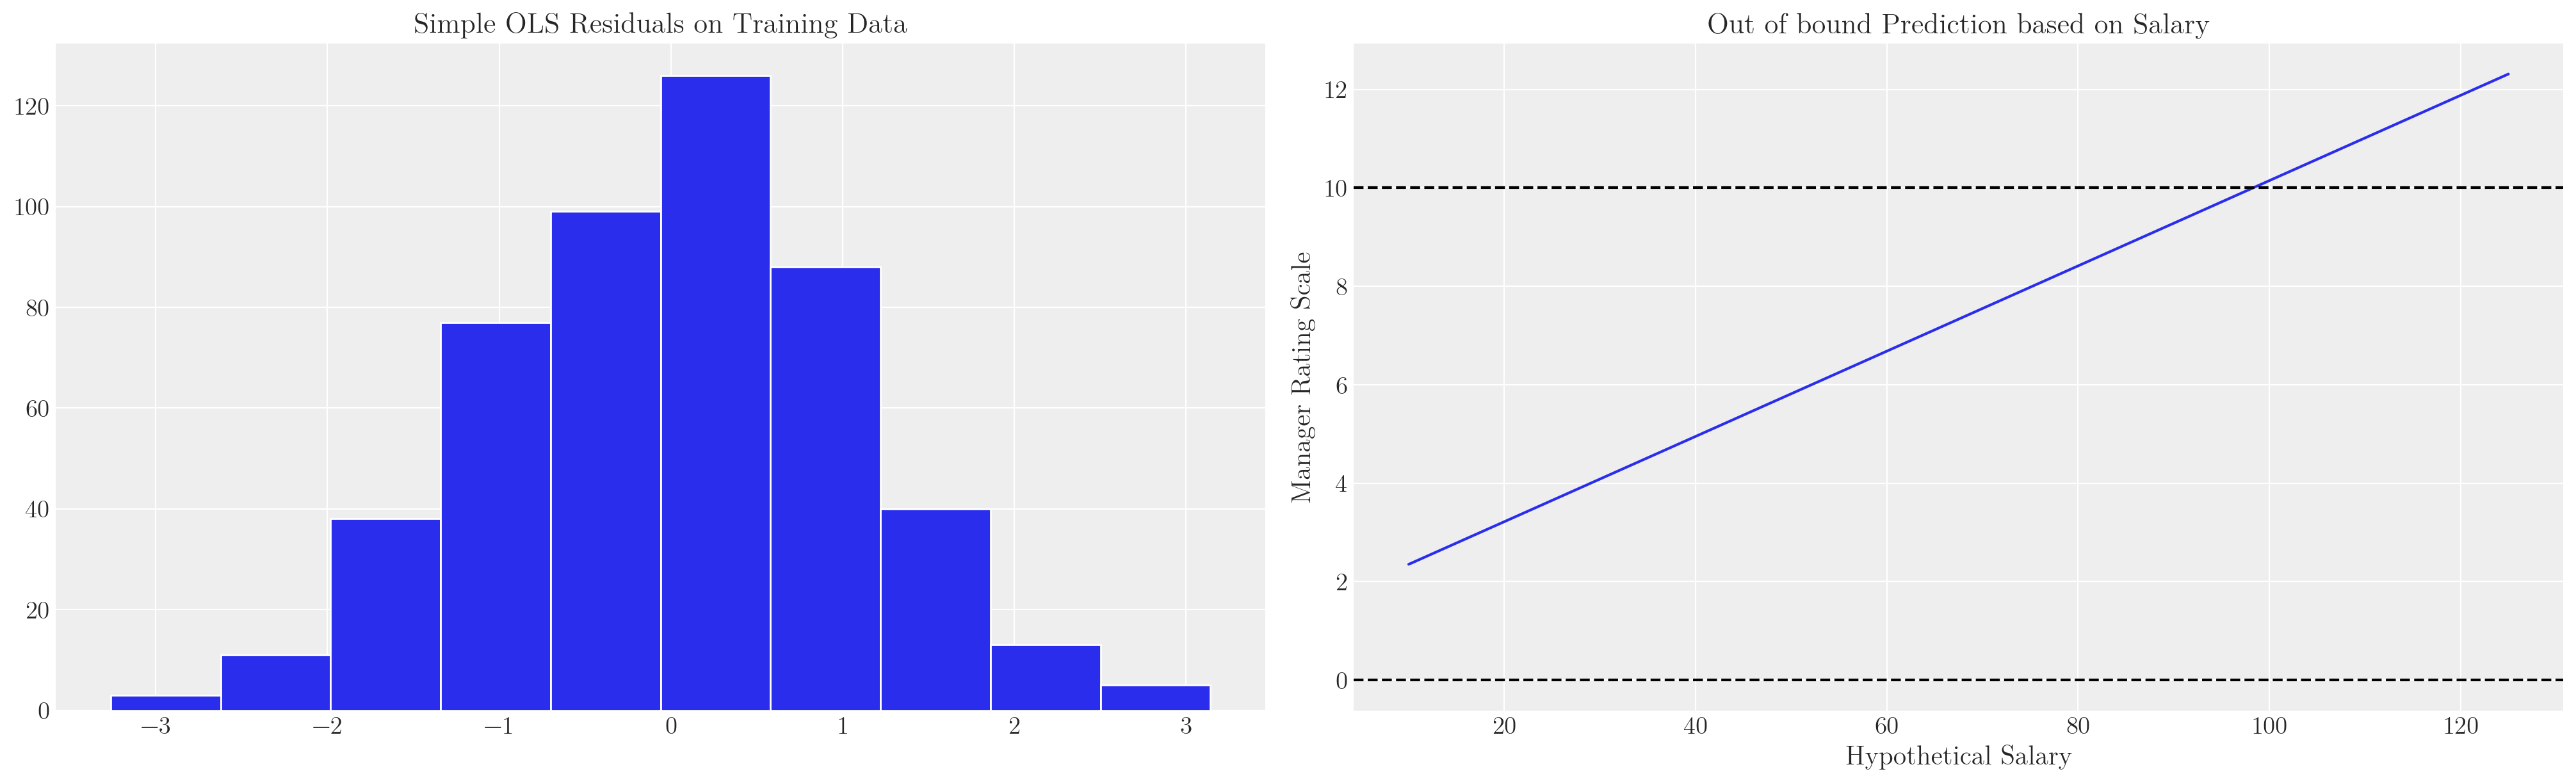

In [6]:
exog = sm.add_constant(df[["salary", "work_from_home", "work_sat"]])
mod = sm.OLS(df["explicit_rating"], exog)
results = mod.fit()
results.summary()

results.predict([1, 200, 1, 0.6])
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
ax = axs[1]
salaries = np.linspace(10, 125, 20)
predictions = [results.predict([1, i, 1, 0.6])[0] for i in salaries]
ax.plot(salaries, predictions, label="Implied Linear function of Salaries on Outcome")
ax.set_title("Out of bound Prediction based on Salary")
ax.axhline(10, linestyle="--", color="black")
ax.set_xlabel("Hypothetical Salary")
ax.set_ylabel("Manager Rating Scale")
ax.axhline(0, linestyle="--", color="black")
axs[0].hist(results.resid, ec="white")
axs[0].set_title("Simple OLS Residuals on Training Data")

In [7]:
def constrainedUniform(N, min=0, max=1):
    return pm.Deterministic(
        "cutpoints",
        pt.concatenate(
            [
                np.ones(1) * min,
                pt.extra_ops.cumsum(pm.Dirichlet("cuts_unknown", a=np.ones(N - 2))) * (max - min)
                + min,
            ]
        ),
    )

In [8]:
def make_model(priors, model_spec=1, constrained_uniform=False, logit=True):
    with pm.Model() as model:
        if constrained_uniform:
            cutpoints = constrainedUniform(K, 0, K)
        else:
            sigma = pm.Exponential("sigma", priors["sigma"])
            cutpoints = pm.Normal(
                "cutpoints",
                mu=priors["mu"],
                sigma=sigma,
                transform=pm.distributions.transforms.ordered,
            )

        if model_spec == 1:
            beta = pm.Normal("beta", priors["beta"][0], priors["beta"][1], size=1)
            mu = pm.Deterministic("mu", beta[0] * df.salary)
        elif model_spec == 2:
            beta = pm.Normal("beta", priors["beta"][0], priors["beta"][1], size=2)
            mu = pm.Deterministic("mu", beta[0] * df.salary + beta[1] * df.work_sat)
        elif model_spec == 3:
            beta = pm.Normal("beta", priors["beta"][0], priors["beta"][1], size=3)
            mu = pm.Deterministic(
                "mu", beta[0] * df.salary + beta[1] * df.work_sat + beta[2] * df.work_from_home
            )
        if logit:
            y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=mu, observed=df.explicit_rating)
        else:
            y_ = pm.OrderedProbit("y", cutpoints=cutpoints, eta=mu, observed=df.explicit_rating)
        idata = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata, model


priors = {"sigma": 1, "beta": [0, 1], "mu": np.linspace(0, K, K - 1)}
idata1, model1 = make_model(priors, model_spec=1)
idata2, model2 = make_model(priors, model_spec=2)
idata3, model3 = make_model(priors, model_spec=3)
idata4, model4 = make_model(priors, model_spec=3, constrained_uniform=True)
idata5, model5 = make_model(priors, model_spec=3, constrained_uniform=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


Output()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [y]


Output()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [y]


Output()

In [9]:
az.summary(idata3, var_names=["sigma", "cutpoints", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,2.237,0.733,0.845,3.551,0.017,0.012,1752.0,1723.0,1.0
cutpoints[0],-0.741,0.962,-2.649,0.953,0.023,0.017,1774.0,2082.0,1.0
cutpoints[1],1.728,0.559,0.666,2.747,0.011,0.008,2457.0,2800.0,1.0
cutpoints[2],3.801,0.527,2.842,4.813,0.012,0.009,1859.0,1882.0,1.0
cutpoints[3],5.395,0.549,4.324,6.394,0.013,0.009,1716.0,1772.0,1.0
cutpoints[4],7.047,0.602,5.891,8.185,0.015,0.010,1643.0,1705.0,1.0
cutpoints[5],8.511,0.651,7.309,9.781,0.016,0.012,1598.0,1729.0,1.0
cutpoints[6],10.475,0.725,9.054,11.783,0.018,0.013,1574.0,1692.0,1.0
cutpoints[7],11.889,0.802,10.385,13.388,0.020,0.014,1614.0,1533.0,1.0
cutpoints[8],13.237,0.939,11.543,15.113,0.023,0.016,1727.0,1741.0,1.0


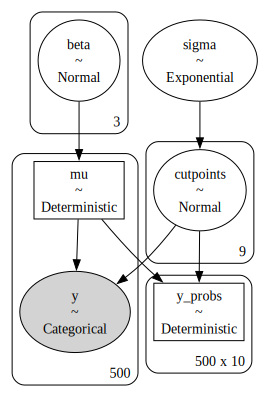

In [10]:
pm.model_to_graphviz(model3)

In [11]:
implied_probs = az.extract(idata3, var_names=["y_probs"])
implied_probs.shape

(500, 10, 4000)

In [12]:
implied_probs[0].mean(axis=1)

<xarray.DataArray 'y_probs' (y_probs_dim_1: 10)> Size: 80B
array([0.00296572, 0.02180526, 0.13602712, 0.32097524, 0.34532643,
       0.1262012 , 0.0396869 , 0.00523066, 0.00127461, 0.00050687])
Coordinates:
    y_probs_dim_0  int64 8B 0
  * y_probs_dim_1  (y_probs_dim_1) int64 80B 0 1 2 3 4 5 6 7 8 9

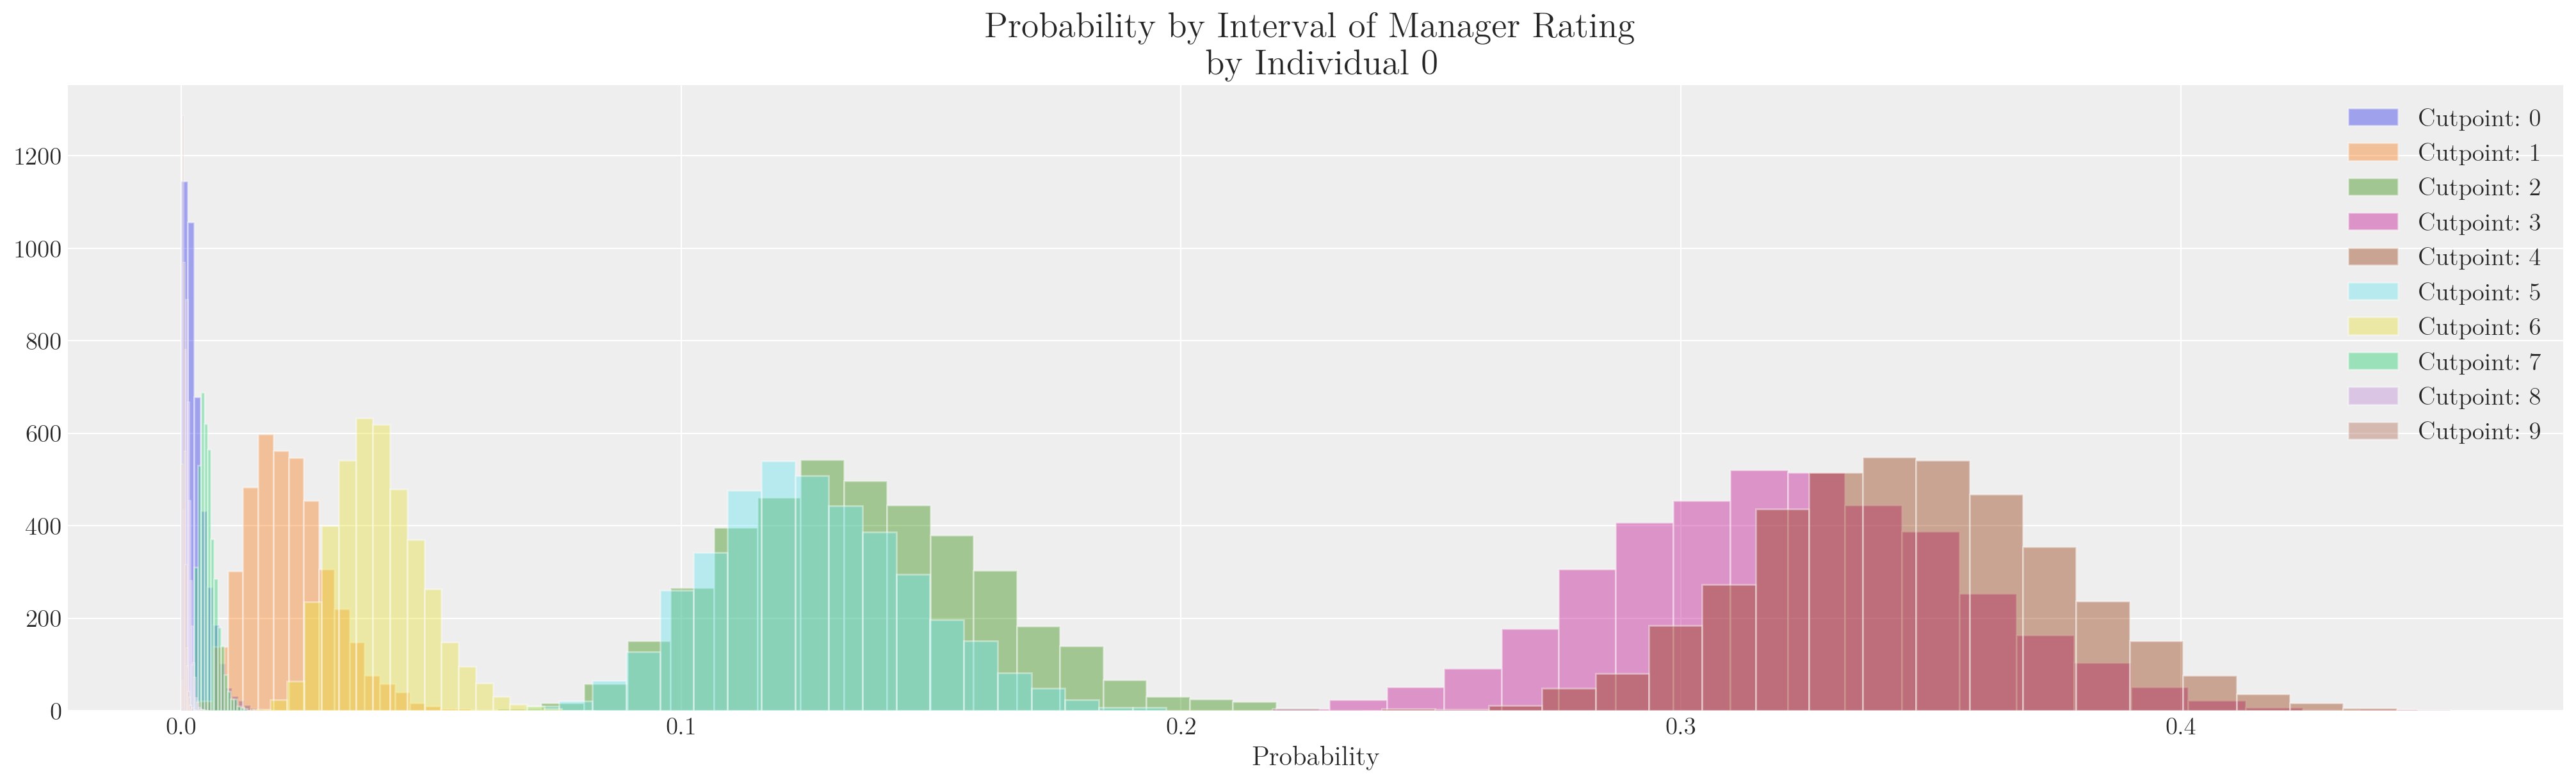

In [13]:
fig, ax = plt.subplots(figsize=(20, 6))
for i in range(K):
    ax.hist(implied_probs[0, i, :], label=f"Cutpoint: {i}", ec="white", bins=20, alpha=0.4)
ax.set_xlabel("Probability")
ax.set_title("Probability by Interval of Manager Rating \n by Individual 0", fontsize=20)
ax.legend();

In [14]:
implied_class = az.extract(idata3, var_names=["y"], group="posterior_predictive")
implied_class.shape

(500, 4000)

In [15]:
from scipy.stats import mode

mode(implied_class[0])

ModeResult(mode=4, count=1398)

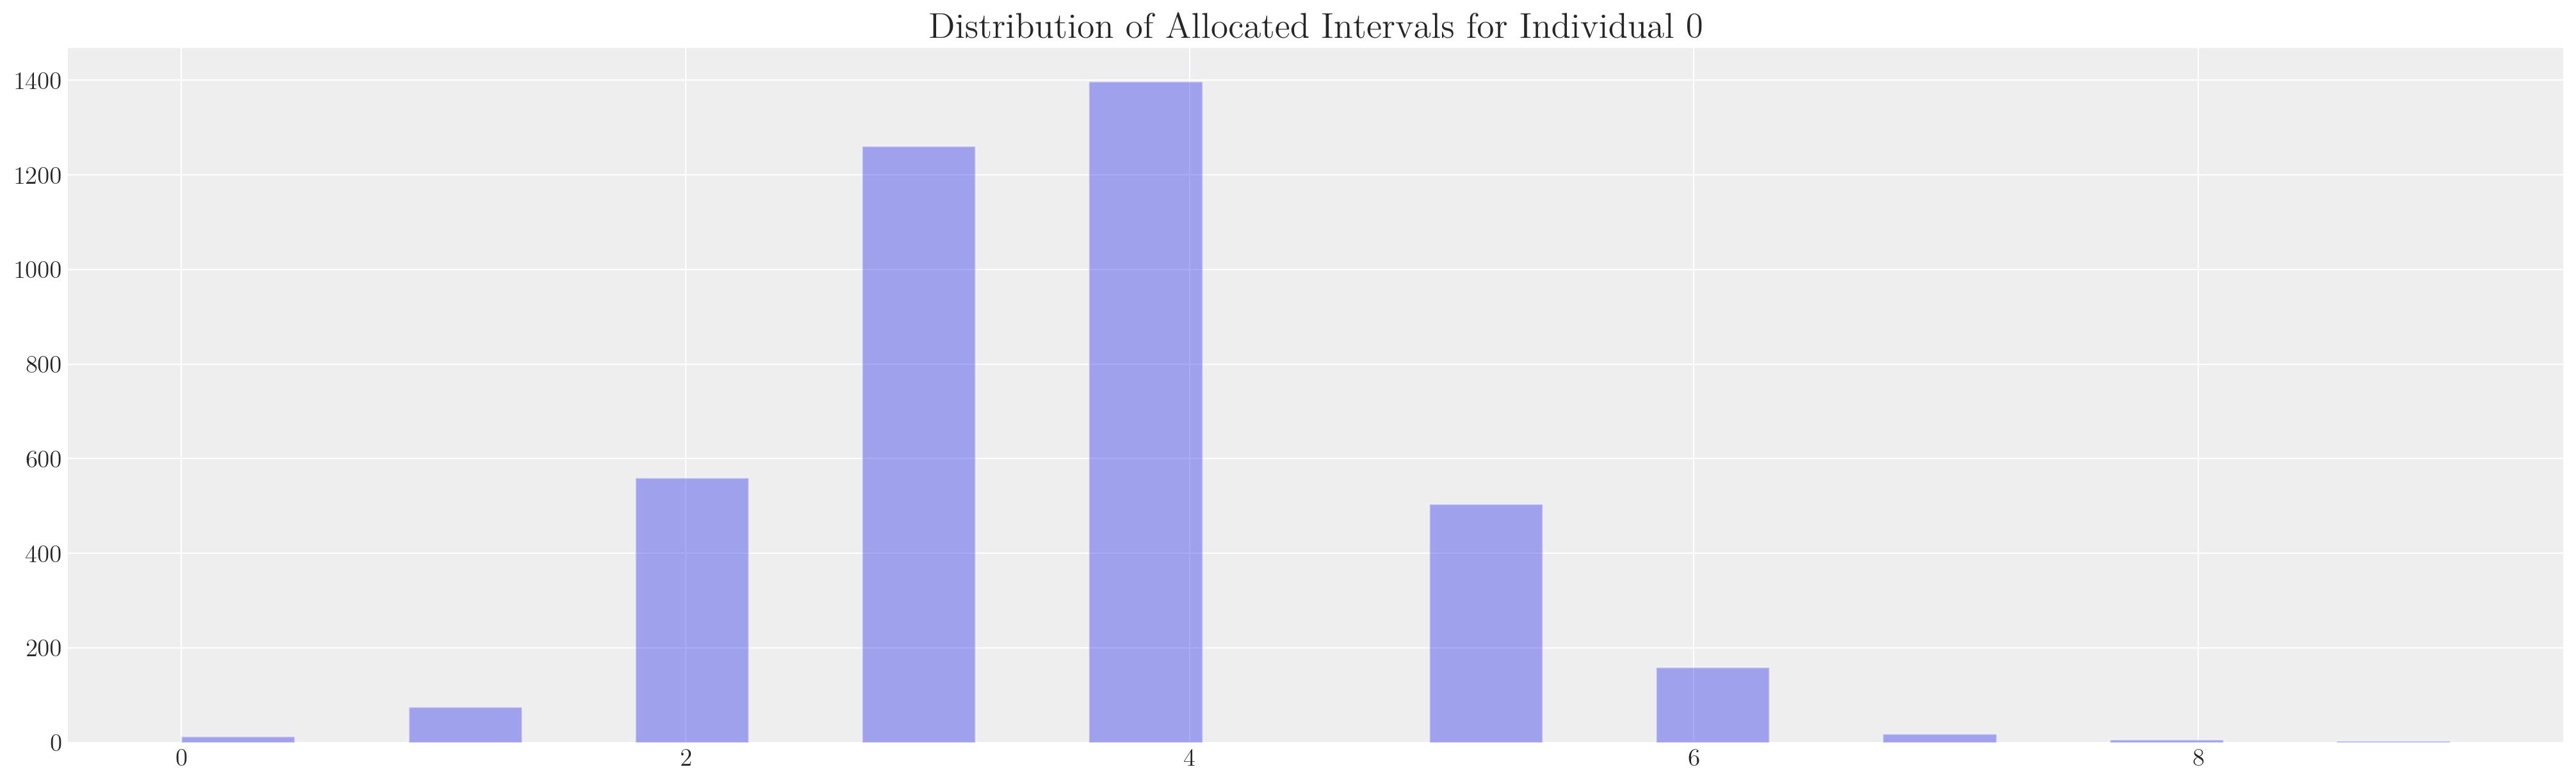

In [16]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist(implied_class[0], ec="white", bins=20, alpha=0.4)
ax.set_title("Distribution of Allocated Intervals for Individual 0", fontsize=20);

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_full,0,-745.007128,11.687724,0.000000,1.000000e+00,14.843717,0.000000,False,log
constrained_logit_full,1,-762.285390,8.565007,17.278262,0.000000e+00,12.979439,4.040985,False,log
constrained_probit_full,2,-762.453283,8.725616,17.446156,0.000000e+00,12.991534,4.038101,False,log
model_salary_worksat,3,-830.223595,7.330757,85.216467,2.369216e-13,13.914050,10.738691,False,log
model_salary,4,-831.283290,7.445823,86.276162,5.598411e-11,14.583666,10.915365,False,log


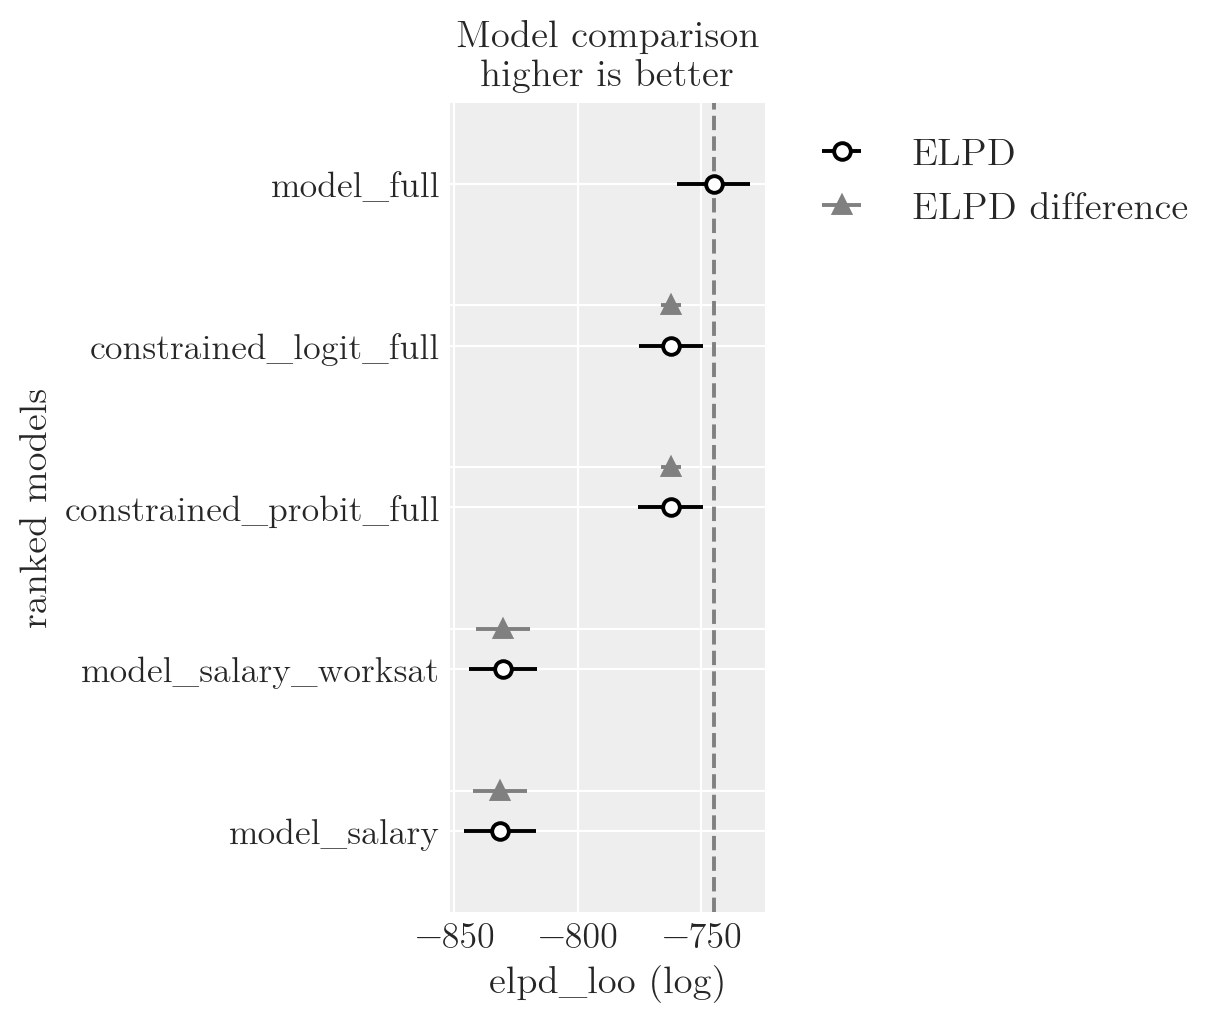

In [17]:
compare = az.compare(
    {
        "model_salary": idata1,
        "model_salary_worksat": idata2,
        "model_full": idata3,
        "constrained_logit_full": idata4,
        "constrained_probit_full": idata5,
    }
)

az.plot_compare(compare)
compare

/Users/gzheng/projects/professional/likert_dualresponse/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


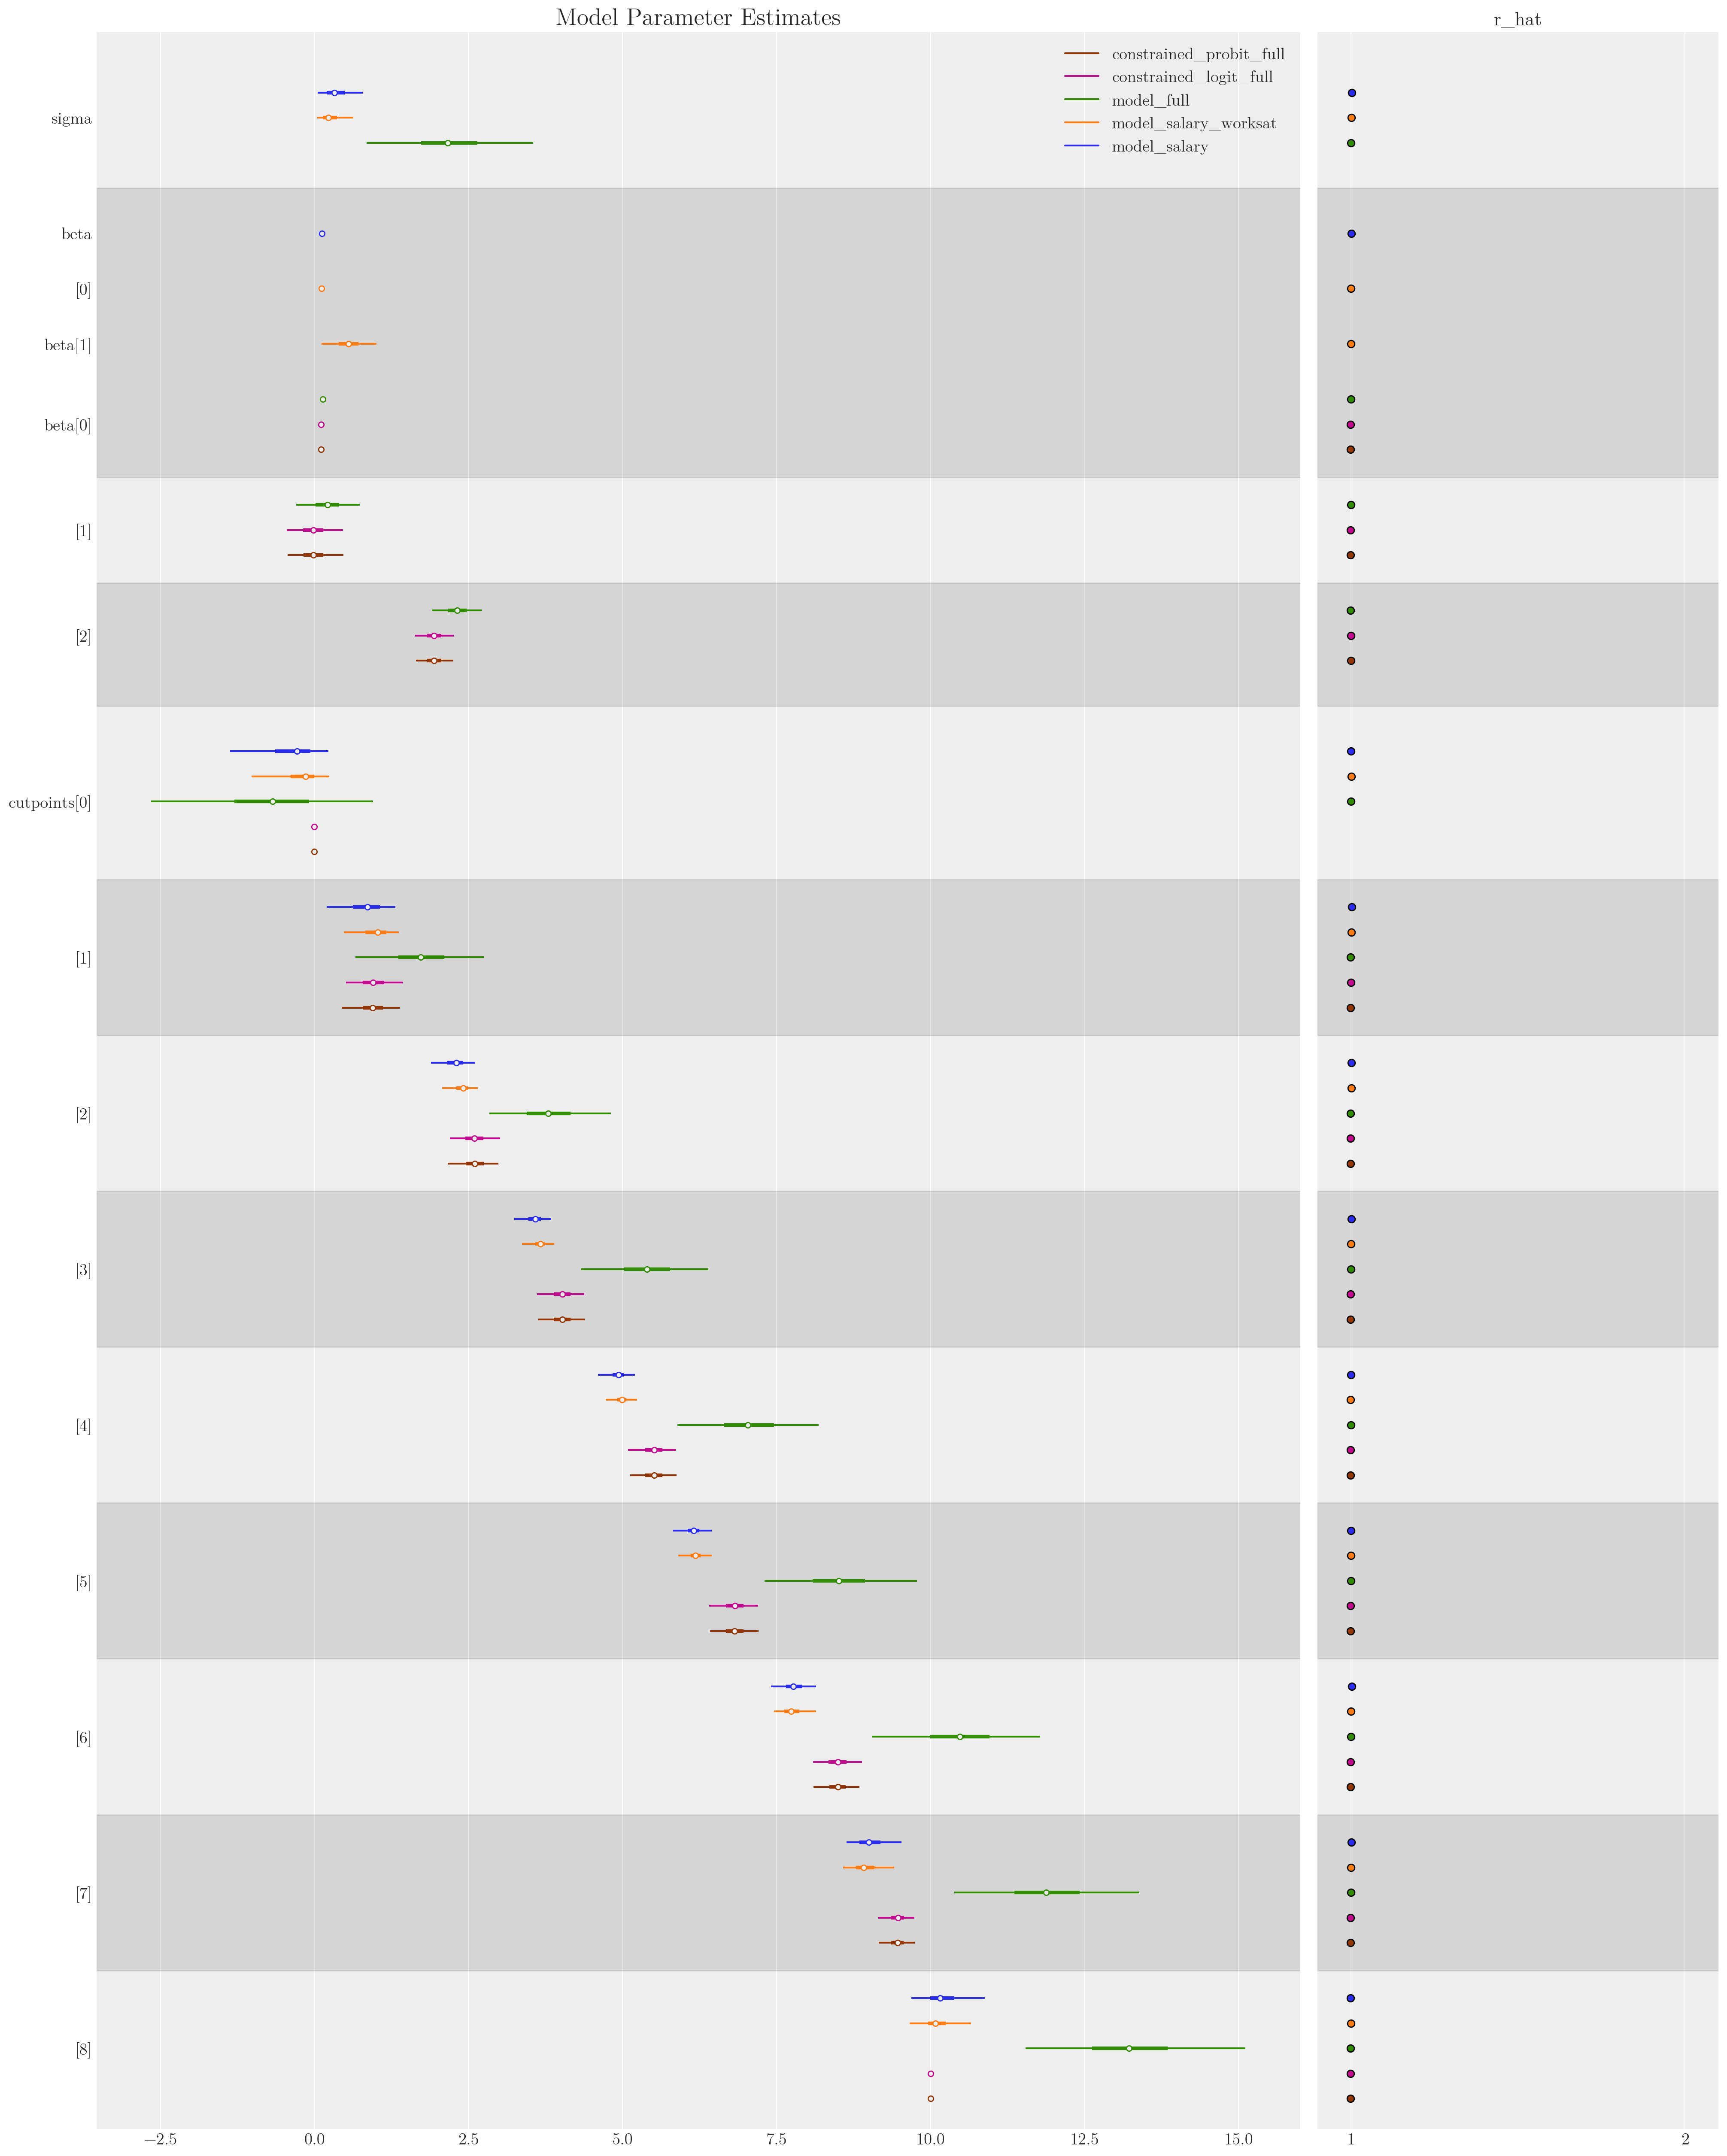

In [18]:
ax = az.plot_forest(
    [idata1, idata2, idata3, idata4, idata5],
    var_names=["sigma", "beta", "cutpoints"],
    combined=True,
    ridgeplot_overlap=4,
    figsize=(20, 25),
    r_hat=True,
    ridgeplot_alpha=0.3,
    model_names=[
        "model_salary",
        "model_salary_worksat",
        "model_full",
        "constrained_logit_full",
        "constrained_probit_full",
    ],
)
ax[0].set_title("Model Parameter Estimates", fontsize=20);

In [19]:
az.summary(idata3, var_names=["cutpoints", "beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],-0.741,0.962,-2.649,0.953,0.023,0.017,1774.0,2082.0,1.0
cutpoints[1],1.728,0.559,0.666,2.747,0.011,0.008,2457.0,2800.0,1.0
cutpoints[2],3.801,0.527,2.842,4.813,0.012,0.009,1859.0,1882.0,1.0
cutpoints[3],5.395,0.549,4.324,6.394,0.013,0.009,1716.0,1772.0,1.0
cutpoints[4],7.047,0.602,5.891,8.185,0.015,0.010,1643.0,1705.0,1.0
cutpoints[5],8.511,0.651,7.309,9.781,0.016,0.012,1598.0,1729.0,1.0
cutpoints[6],10.475,0.725,9.054,11.783,0.018,0.013,1574.0,1692.0,1.0
cutpoints[7],11.889,0.802,10.385,13.388,0.020,0.014,1614.0,1533.0,1.0
cutpoints[8],13.237,0.939,11.543,15.113,0.023,0.016,1727.0,1741.0,1.0
beta[0],0.133,0.011,0.113,0.154,0.000,0.000,1886.0,2062.0,1.0


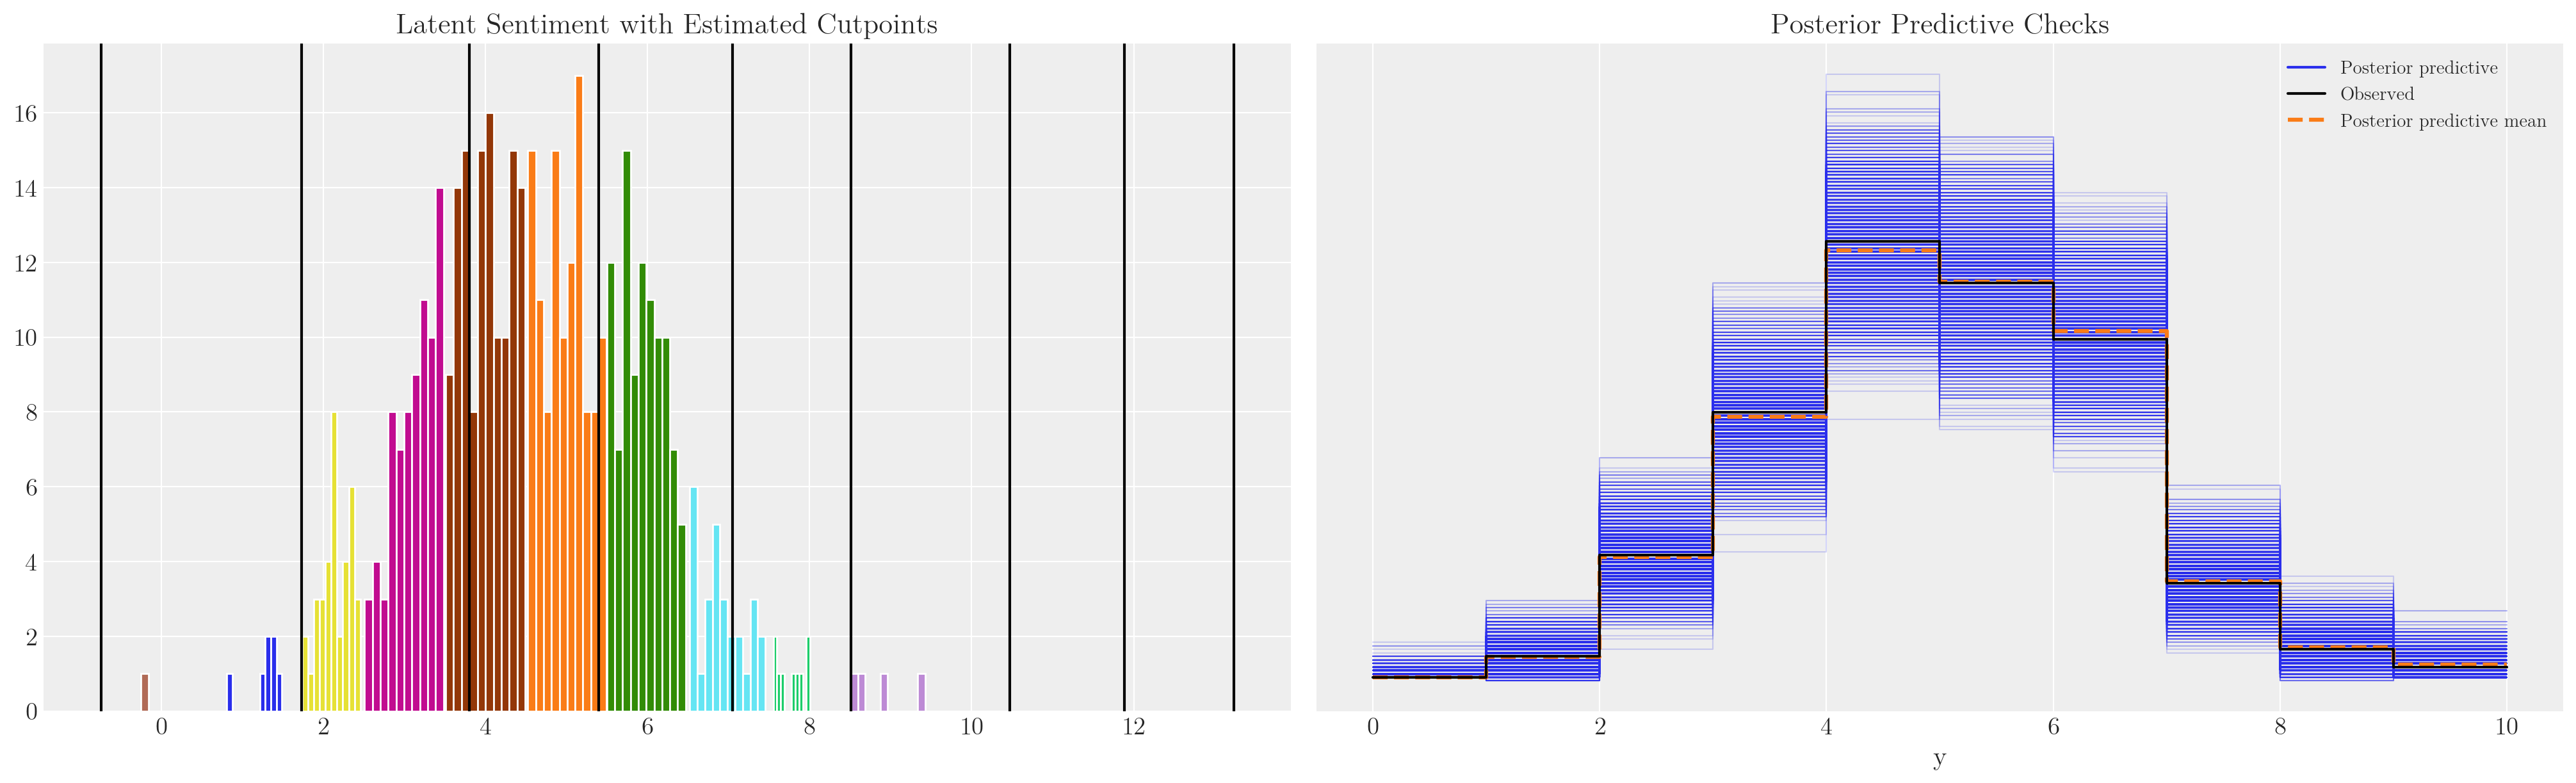

In [20]:
def plot_fit(idata):
    posterior = idata.posterior.stack(sample=("chain", "draw"))
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    axs = axs.flatten()
    ax = axs[0]
    for i in range(K - 1):
        ax.axvline(posterior["cutpoints"][i].mean().values, color="k")
    for r in df["explicit_rating"].unique():
        temp = df[df["explicit_rating"] == r]
        ax.hist(temp["latent_rating"], ec="white")
    ax.set_title("Latent Sentiment with Estimated Cutpoints")
    axs[1].set_title("Posterior Predictive Checks")
    az.plot_ppc(idata, ax=axs[1])
    plt.show()


plot_fit(idata3)

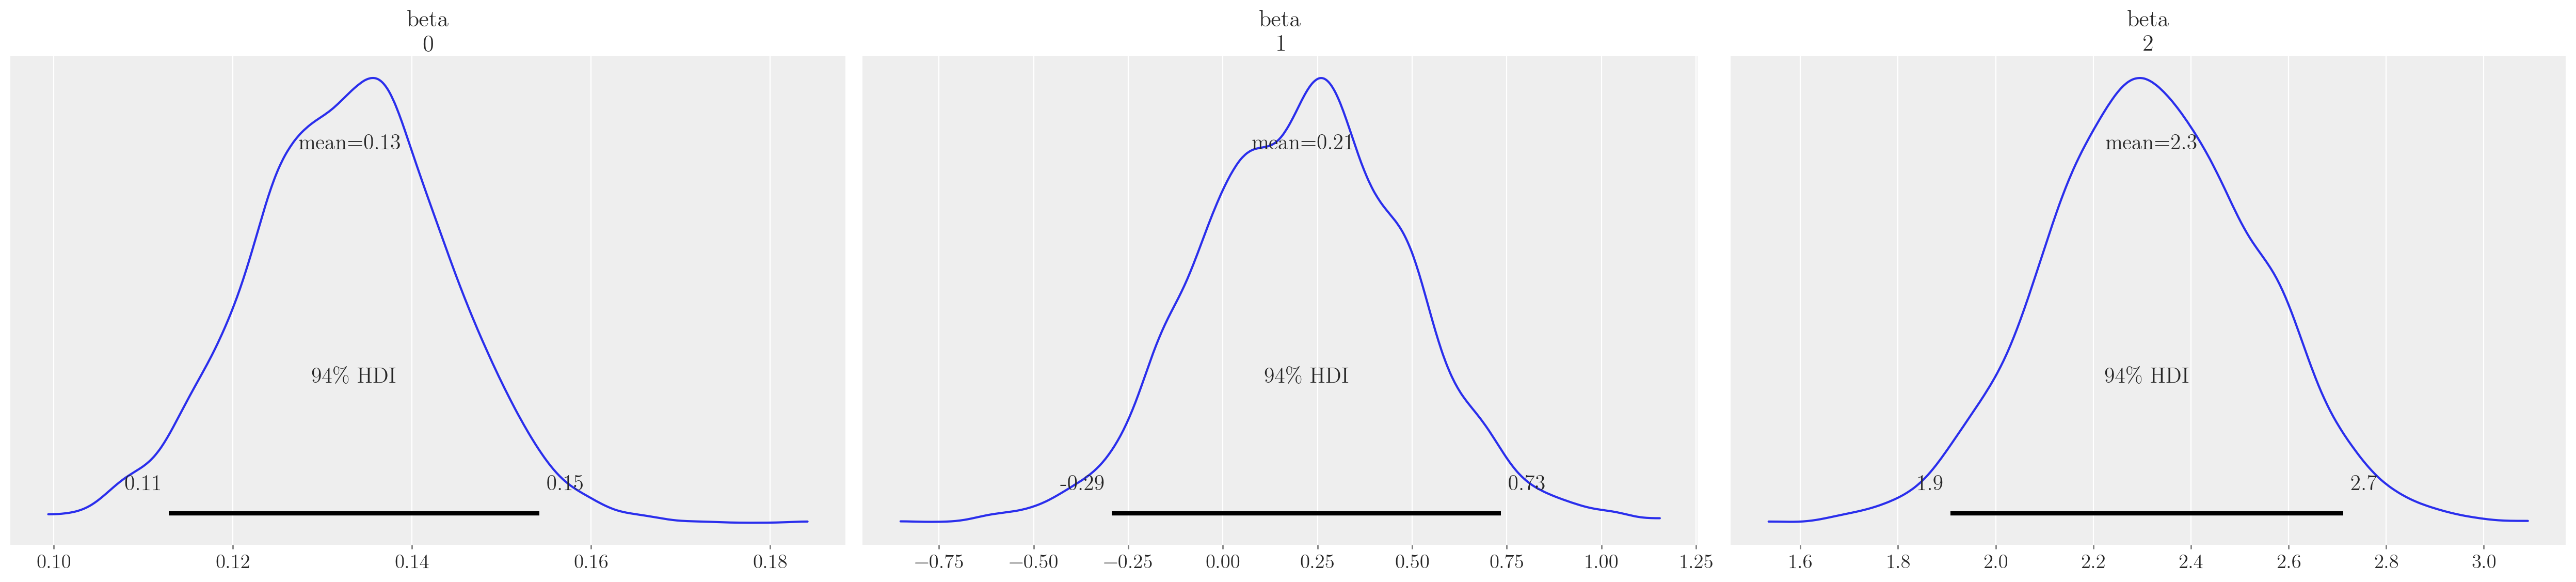

In [21]:
az.plot_posterior(idata3, var_names=["beta"]);

In [22]:
az.summary(idata3, var_names=["cutpoints"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],-0.741,0.962,-2.649,0.953,0.023,0.017,1774.0,2082.0,1.0
cutpoints[1],1.728,0.559,0.666,2.747,0.011,0.008,2457.0,2800.0,1.0
cutpoints[2],3.801,0.527,2.842,4.813,0.012,0.009,1859.0,1882.0,1.0
cutpoints[3],5.395,0.549,4.324,6.394,0.013,0.009,1716.0,1772.0,1.0
cutpoints[4],7.047,0.602,5.891,8.185,0.015,0.010,1643.0,1705.0,1.0
cutpoints[5],8.511,0.651,7.309,9.781,0.016,0.012,1598.0,1729.0,1.0
cutpoints[6],10.475,0.725,9.054,11.783,0.018,0.013,1574.0,1692.0,1.0
cutpoints[7],11.889,0.802,10.385,13.388,0.020,0.014,1614.0,1533.0,1.0
cutpoints[8],13.237,0.939,11.543,15.113,0.023,0.016,1727.0,1741.0,1.0


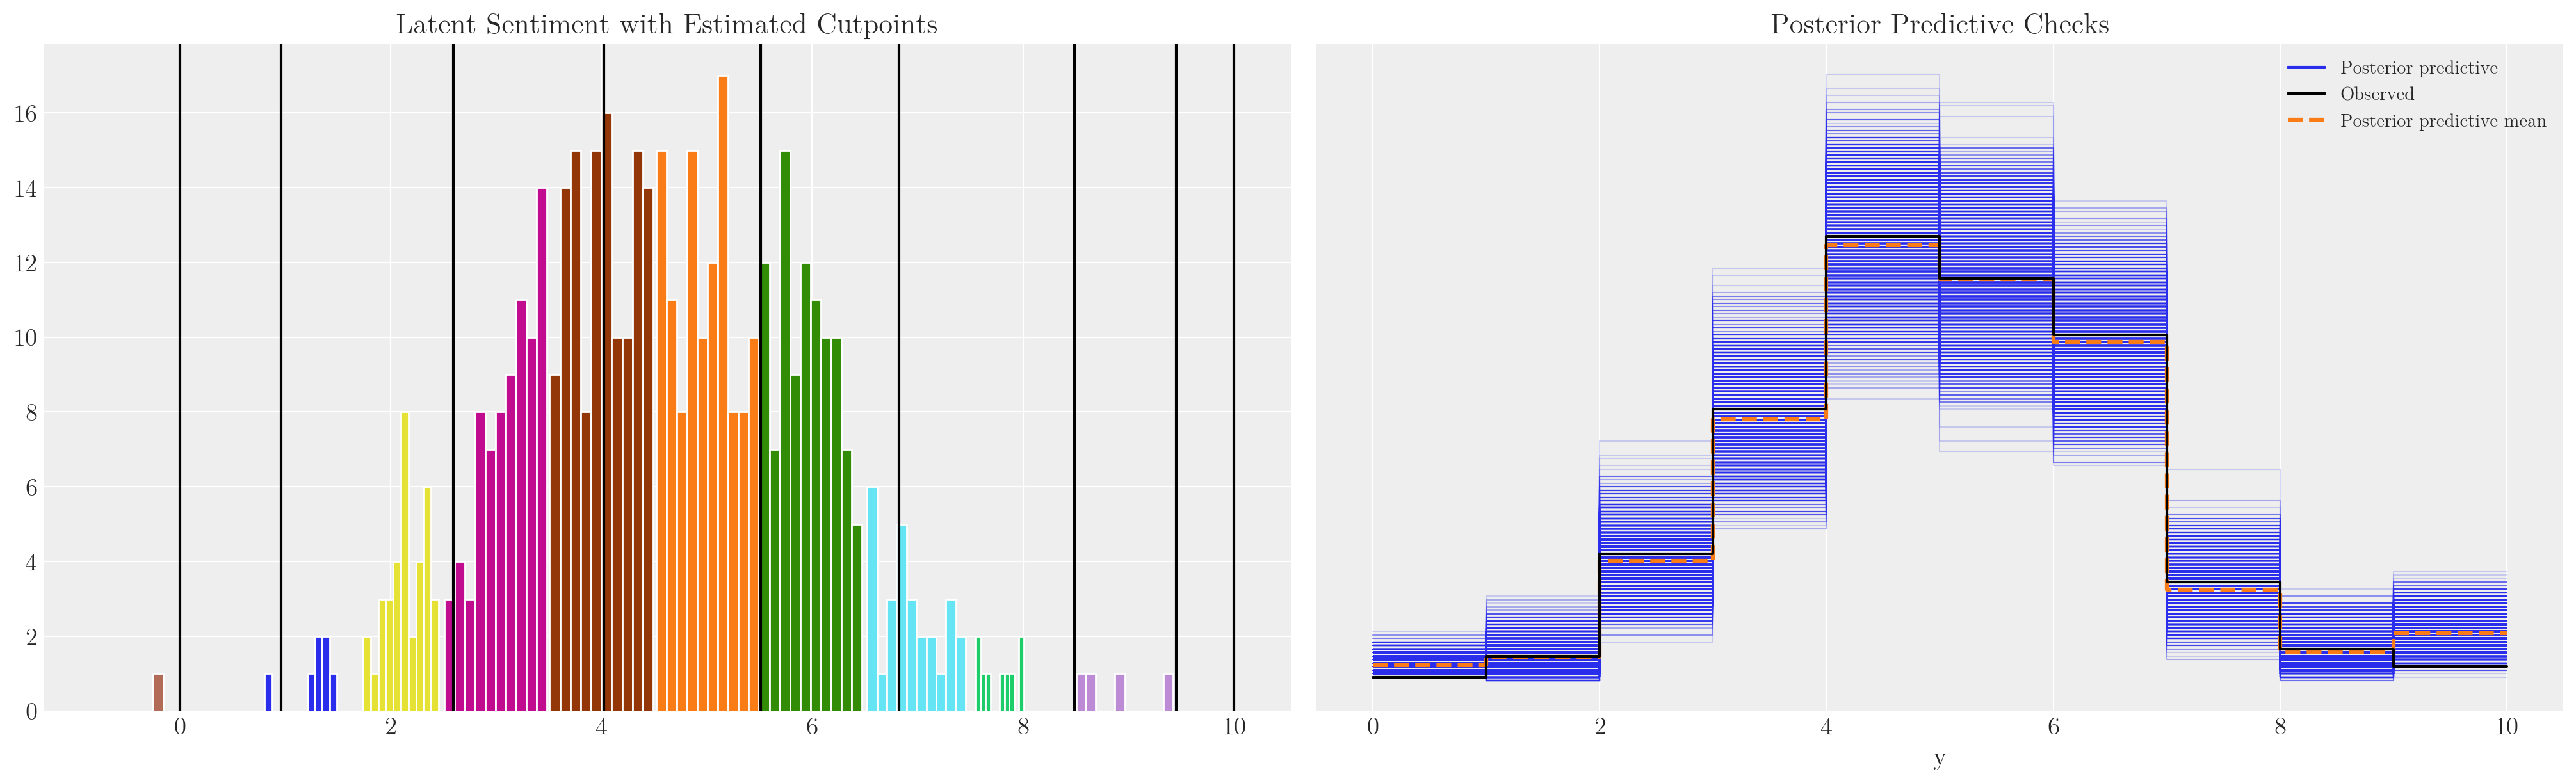

In [23]:
plot_fit(idata4)

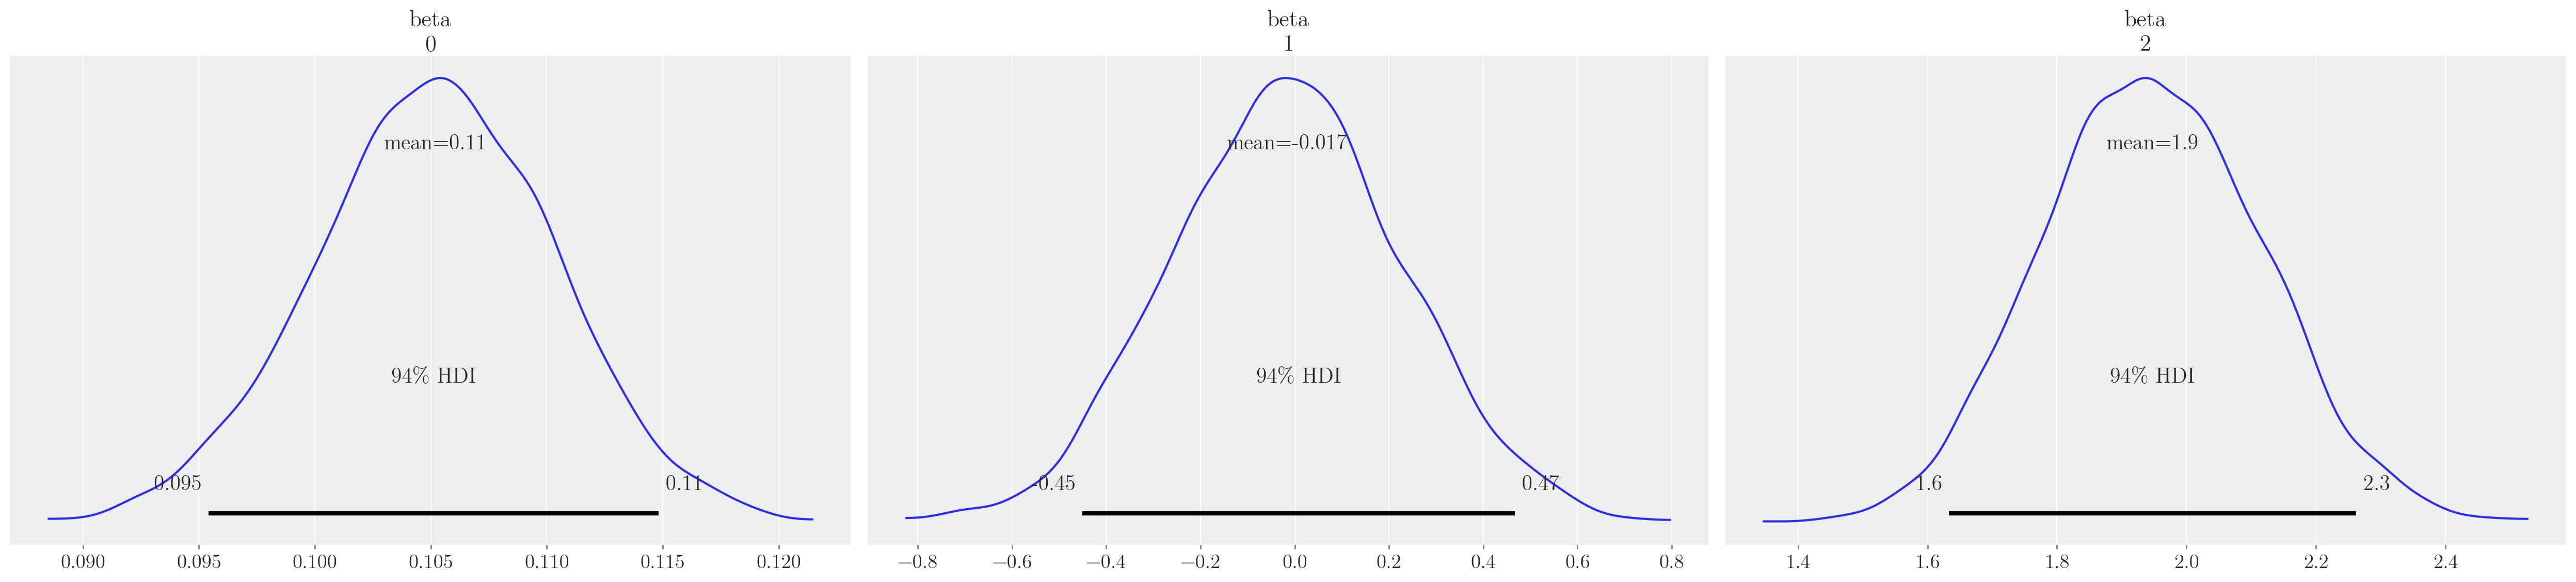

In [24]:
az.plot_posterior(idata4, var_names=["beta"]);

In [25]:
az.summary(idata4, var_names=["cutpoints"])

/Users/gzheng/projects/professional/likert_dualresponse/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
cutpoints[1],0.960,0.251,0.512,1.430,0.005,0.003,2923.0,2730.0,1.0
cutpoints[2],2.596,0.218,2.199,3.012,0.003,0.002,5246.0,3327.0,1.0
cutpoints[3],4.022,0.204,3.610,4.381,0.003,0.002,5353.0,3356.0,1.0
cutpoints[4],5.511,0.206,5.087,5.863,0.003,0.002,4965.0,3436.0,1.0
cutpoints[5],6.821,0.213,6.410,7.201,0.003,0.002,4131.0,3028.0,1.0
cutpoints[6],8.490,0.211,8.094,8.885,0.004,0.003,3465.0,2656.0,1.0
cutpoints[7],9.456,0.160,9.156,9.736,0.002,0.002,5230.0,3069.0,1.0
cutpoints[8],10.000,0.000,10.000,10.000,0.000,0.000,3793.0,3780.0,1.0


Compare to `statsmodels` frequentist estimation

In [26]:
modf_logit = OrderedModel.from_formula(
    "explicit_rating ~ salary + work_sat + work_from_home", df, distr="logit"
)
resf_logit = modf_logit.fit(method="bfgs")
resf_logit.summary()

Optimization terminated successfully.
         Current function value: 1.460454
         Iterations: 78
         Function evaluations: 86
         Gradient evaluations: 86


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:        explicit_rating   Log-Likelihood:                -730.23
Model:                   OrderedModel   AIC:                             1484.
Method:            Maximum Likelihood   BIC:                             1535.
Date:                Sun, 23 Jun 2024                                         
Time:                        13:36:33                                         
No. Observations:                 500                                         
Df Residuals:                     488                                         
Df Model:                           3                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
salary             0.1523      0.010     15.043      0.000       0.132       0.172
work_sat           0.4690      0.289      1.621      0.105      -0.098       1.036
work_from_home     2.6517      0.214     12.391      0.000       2.232       3.071
-0.0/1.0           0.4917      1.082      0.454      0.649      -1.629       2.612
1.0/2.0            0.8069      0.428      1.884      0.060      -0.033       1.646
2.0/3.0            0.7358      0.169      4.361      0.000       0.405       1.067
3.0/4.0            0.5107      0.105      4.868      0.000       0.305       0.716
4.0/5.0            0.5646      0.081      6.952      0.000       0.405       0.724
5.0/6.0            0.4469      0.085      5.246      0.000       0.280       0.614
6.0/7.0            0.7440      0.092      8.088      0.000       0.564       0.924
7.0/8.0            0.4182      0.182      2.295      0.022       0.061       0.775
8.0/9.0            0.3358      0.332      1.013      0.311      -0.314       0.986
==================================================================================
"""

In [27]:
num_of_thresholds = 8
modf_logit.transform_threshold_params(resf_logit.params[-num_of_thresholds:])

array([       -inf,  0.80690515,  2.89414594,  4.56063059,  6.3193155 ,
        7.88272055,  9.98706341, 11.50621999, 12.90532916,         inf])

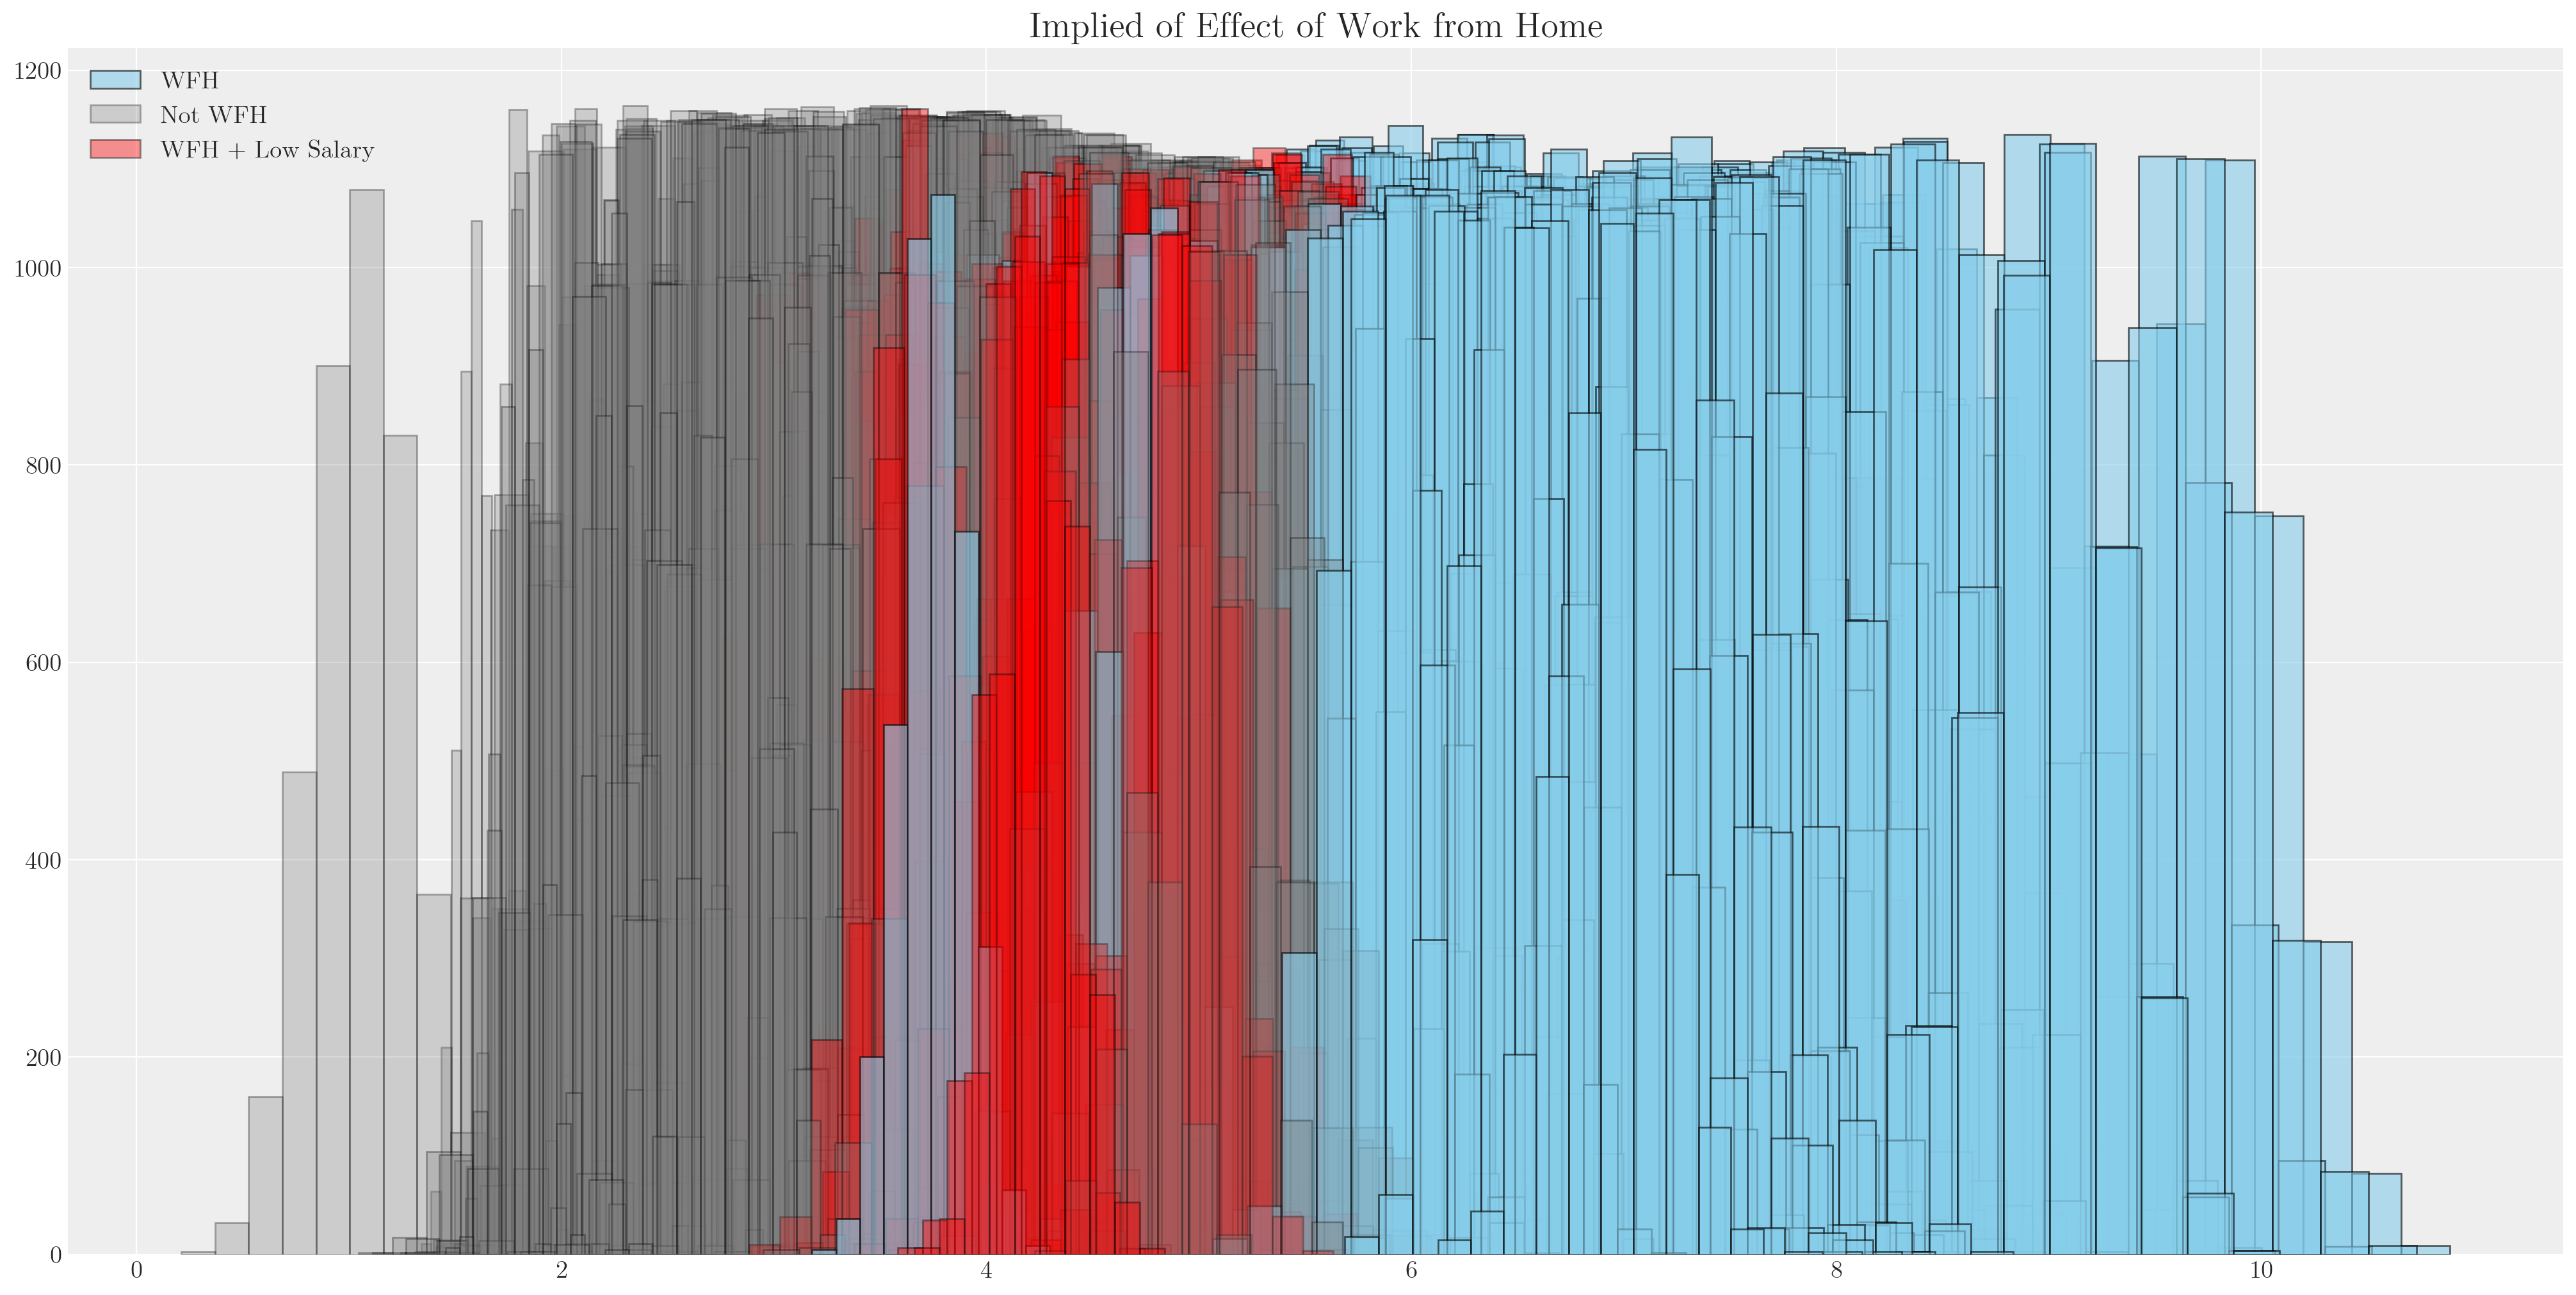

In [28]:
betas_posterior = az.extract(idata4)["beta"]

fig, ax = plt.subplots(figsize=(20, 10))
calc_wfh = [
    df.iloc[i]["salary"] * betas_posterior[0, :]
    + df.iloc[i]["work_sat"] * betas_posterior[1, :]
    + 1 * betas_posterior[2, :]
    for i in range(500)
]
calc_not_wfh = [
    df.iloc[i]["salary"] * betas_posterior[0, :]
    + df.iloc[i]["work_sat"] * betas_posterior[1, :]
    + 0 * betas_posterior[2, :]
    for i in range(500)
]
sal = np.random.normal(25, 5, 500)
calc_wfh_and_low_sal = [
    sal[i] * betas_posterior[0, :]
    + df.iloc[i]["work_sat"] * betas_posterior[1, :]
    + 1 * betas_posterior[2, :]
    for i in range(500)
]

### Use implied threshold on latent score to predict proportion of ratings above 7
prop_wfh = np.sum([np.mean(calc_wfh[i].values) > 6.78 for i in range(500)]) / 500
prop_not_wfh = np.sum([np.mean(calc_not_wfh[i].values) > 6.78 for i in range(500)]) / 500
prop_wfh_low = np.sum([np.mean(calc_wfh_and_low_sal[i].values) > 6.78 for i in range(500)]) / 500

for i in range(500):
    if i == 499:
        ax.hist(calc_wfh[i], alpha=0.6, color="skyblue", ec="black", label="WFH")
        ax.hist(calc_not_wfh[i], alpha=0.3, color="grey", ec="black", label="Not WFH")
        ax.hist(
            calc_wfh_and_low_sal[i], alpha=0.4, color="red", ec="black", label="WFH + Low Salary"
        )
    else:
        ax.hist(calc_wfh[i], alpha=0.6, color="skyblue", ec="black")
        ax.hist(calc_wfh_and_low_sal[i], alpha=0.4, color="red", ec="black")
        ax.hist(calc_not_wfh[i], alpha=0.3, color="grey", ec="black")
ax.set_title("Implied of Effect of Work from Home", fontsize=20)
ax.annotate(
    f"Expected Proportion > 7: \nWFH:{prop_wfh} \nWFH + LOW: {prop_wfh_low} \nNot WFH {prop_not_wfh}",
    xy=(-0.5, 1000),
    fontsize=20,
    fontweight="bold",
)
ax.legend();